## Redes Neuronales - Trabajo Practico N°1 - Clasificación Multiclase
### Dataset Yeast 
es un dataset para construir un predictor de sitios específicos de anclaje de proteínas de levaduras basado en información de las secuencias de aminoácidos que forman a la proteína (problema de clasificación multiclase).

In [51]:
from sys import path
from os.path import realpath
path.append(realpath("../")) # Makes it works everywhere
import pandas as pd
import src.functions as nn
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from keras.utils import to_categorical
from keras.models import Sequential #Para poder definir un modelo secuencial
from keras.layers import Dense, BatchNormalization #Para poder usar capas densas
from keras.optimizers import SGD, Adam
#import src.helper as helper
#import src.multiclass_helper as mc
import matplotlib.pyplot as plt
import numpy as np

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
columns = ["mcg","gvh","alm","mit","erl","pox","vac","nuc"]
df = pd.read_csv("data/yeast.data",names = ["Name"] + columns + ["Class"], sep='\s+')

#### Análisis exploratorio de datos (EDA)


In [6]:
df

,Name,mcg,gvh,alm,mit,erl,pox,vac,nuc,Class
0,ADT1_YEAST,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,ADT2_YEAST,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,ADT3_YEAST,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,AAR2_YEAST,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,AATM_YEAST,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT
...,...,...,...,...,...,...,...,...,...,...
1479,YUR1_YEAST,0.81,0.62,0.43,0.17,0.5,0.0,0.53,0.22,ME2
1480,ZIP1_YEAST,0.47,0.43,0.61,0.40,0.5,0.0,0.48,0.47,NUC
1481,ZNRP_YEAST,0.67,0.57,0.36,0.19,0.5,0.0,0.56,0.22,ME2
1482,ZUO1_YEAST,0.43,0.40,0.60,0.16,0.5,0.0,0.53,0.39,NUC


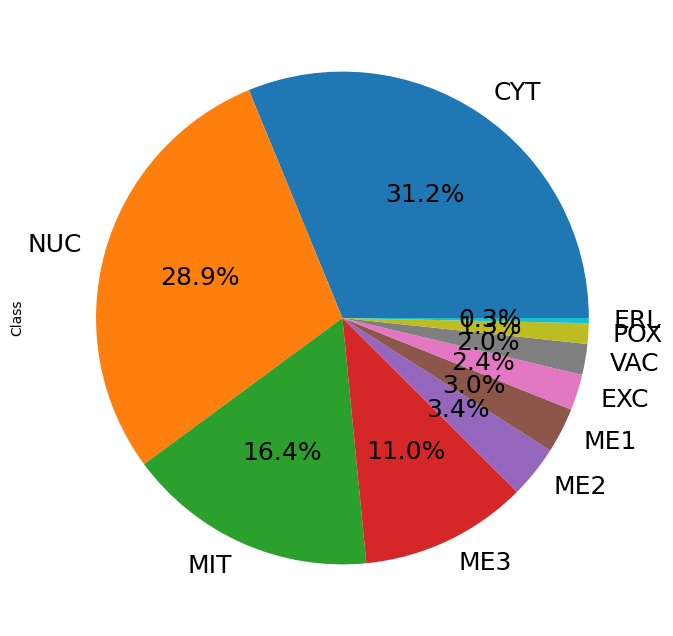

In [7]:
clases = df["Class"].drop_duplicates().to_list()

plot = df['Class'].value_counts().plot( kind='pie', autopct="%.1f%%", fontsize=18, figsize=(8, 8))

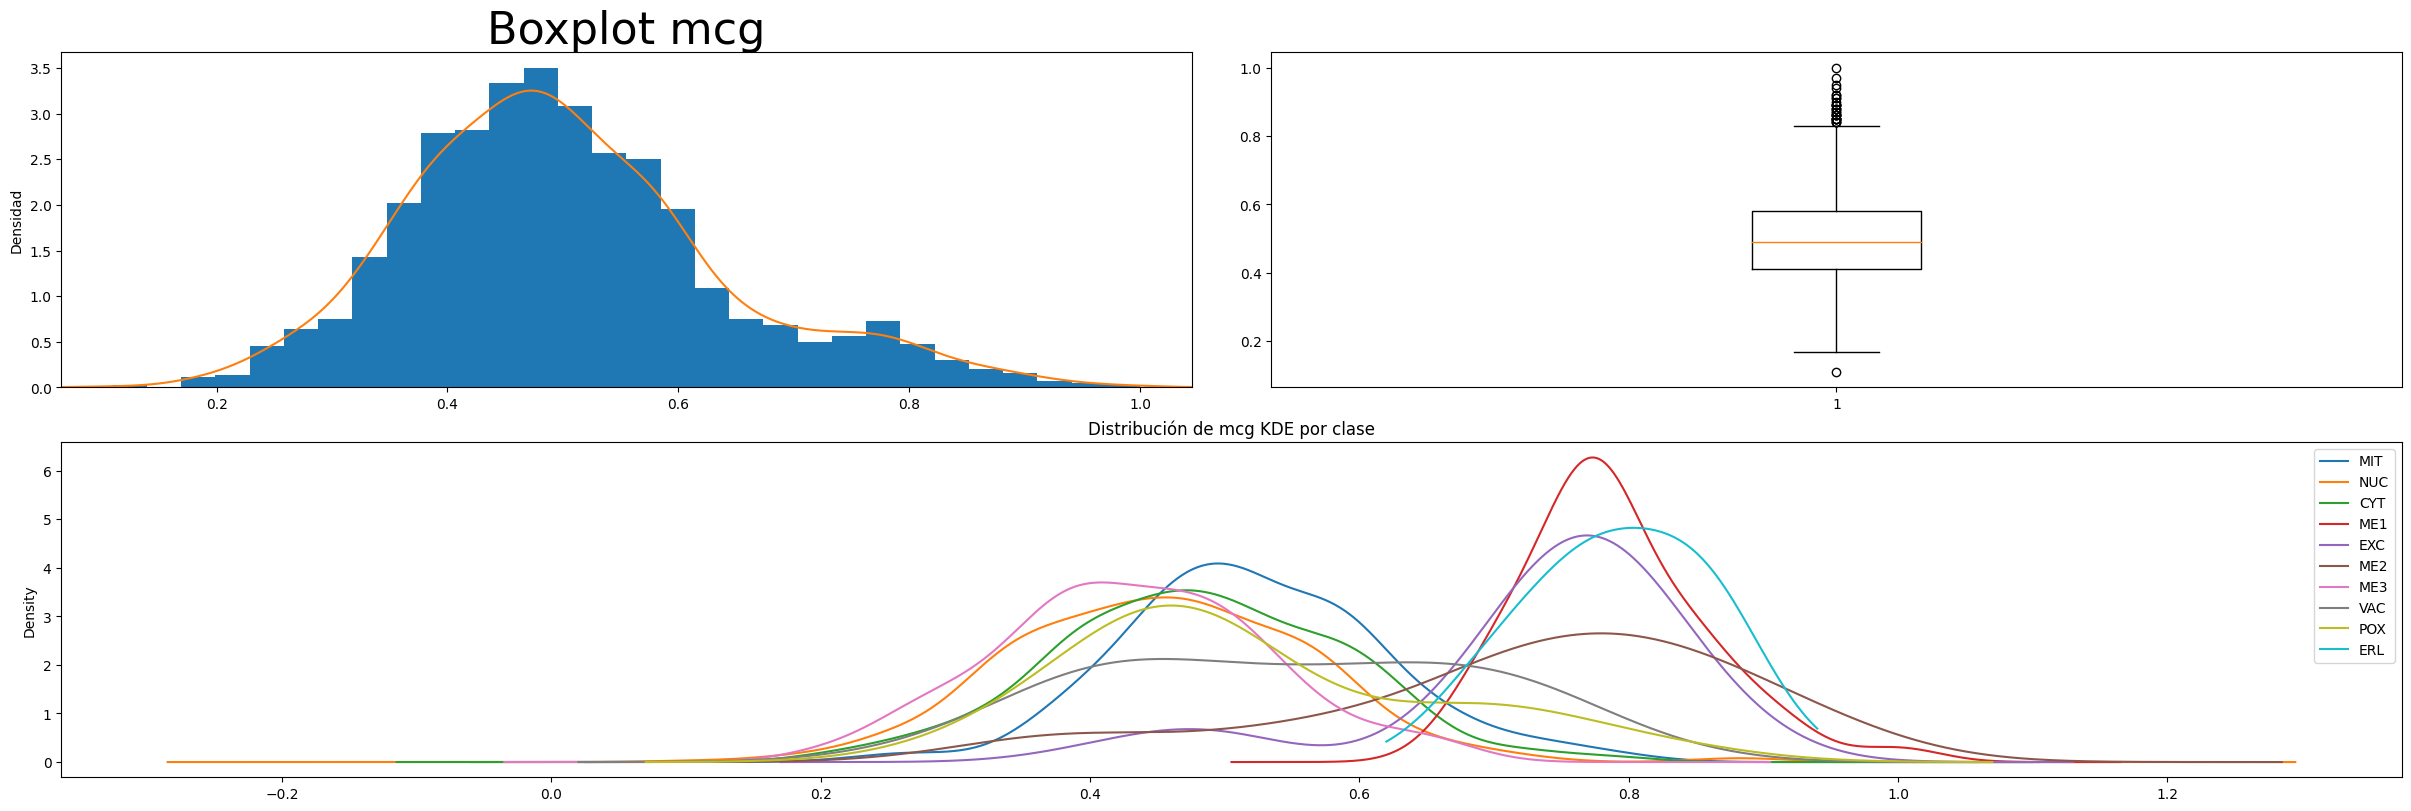

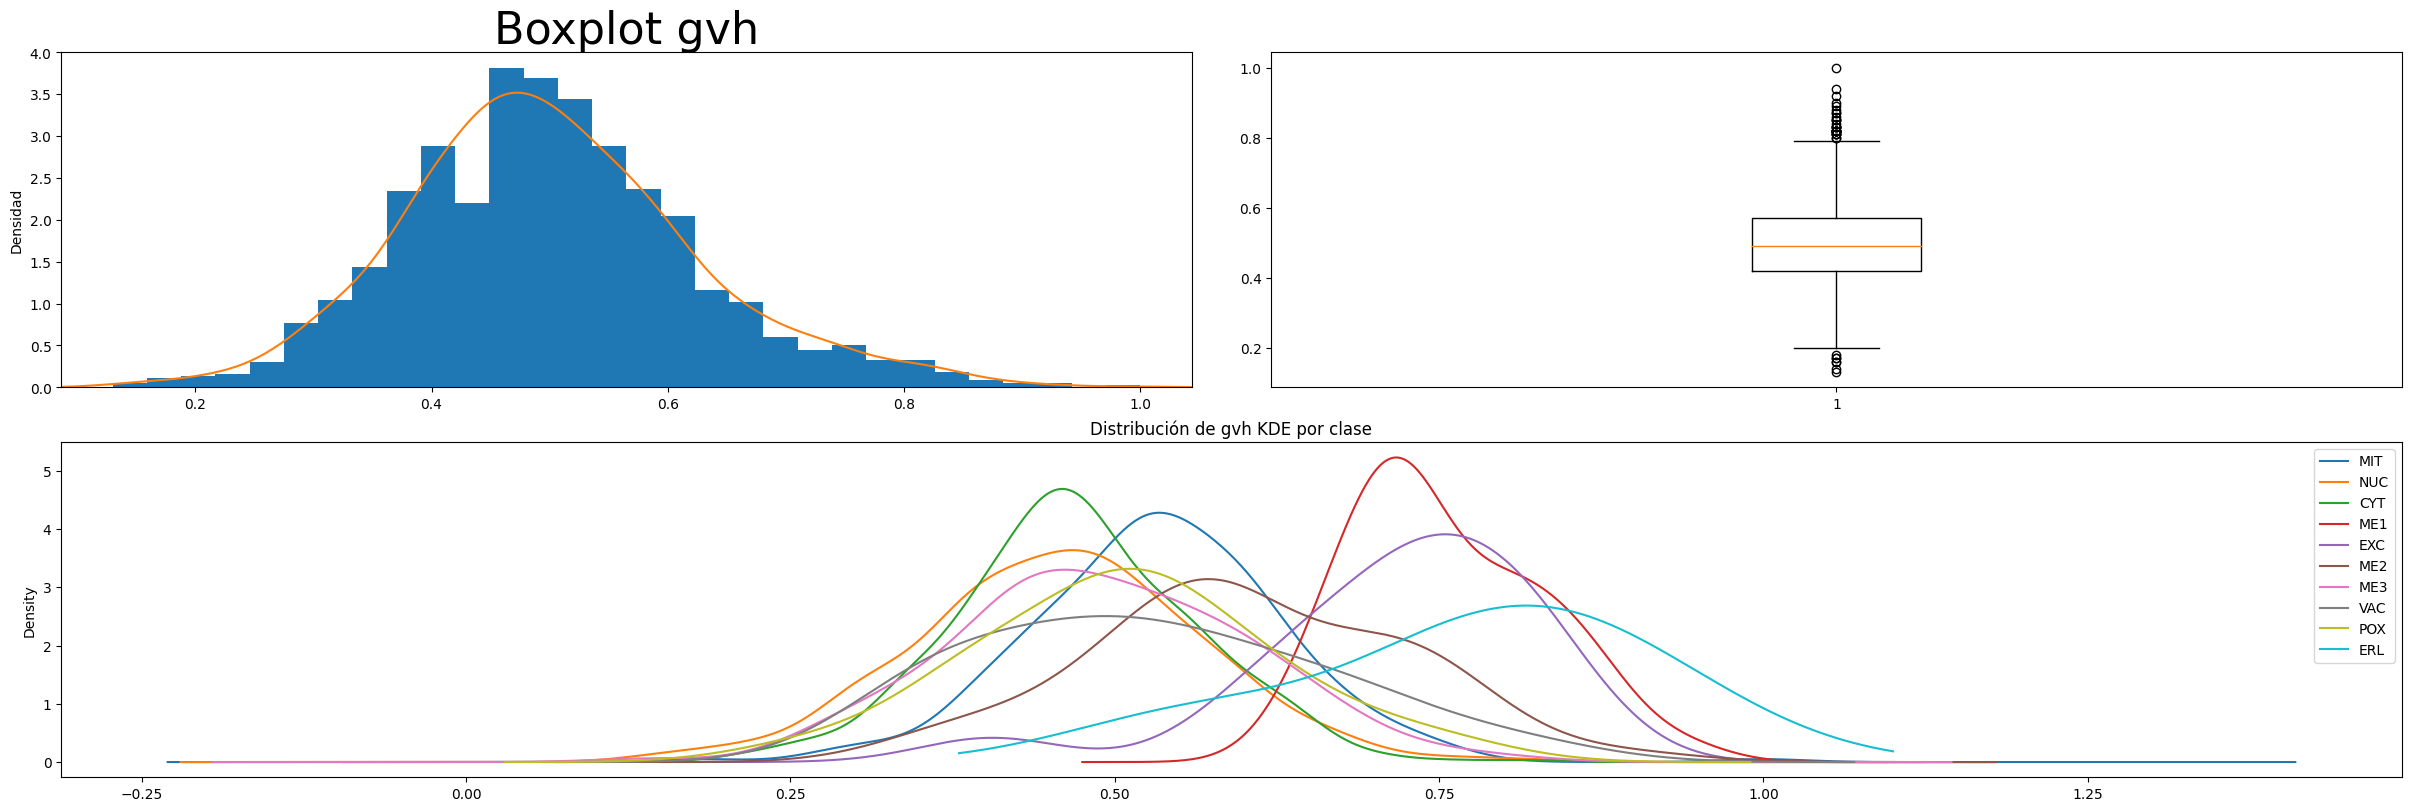

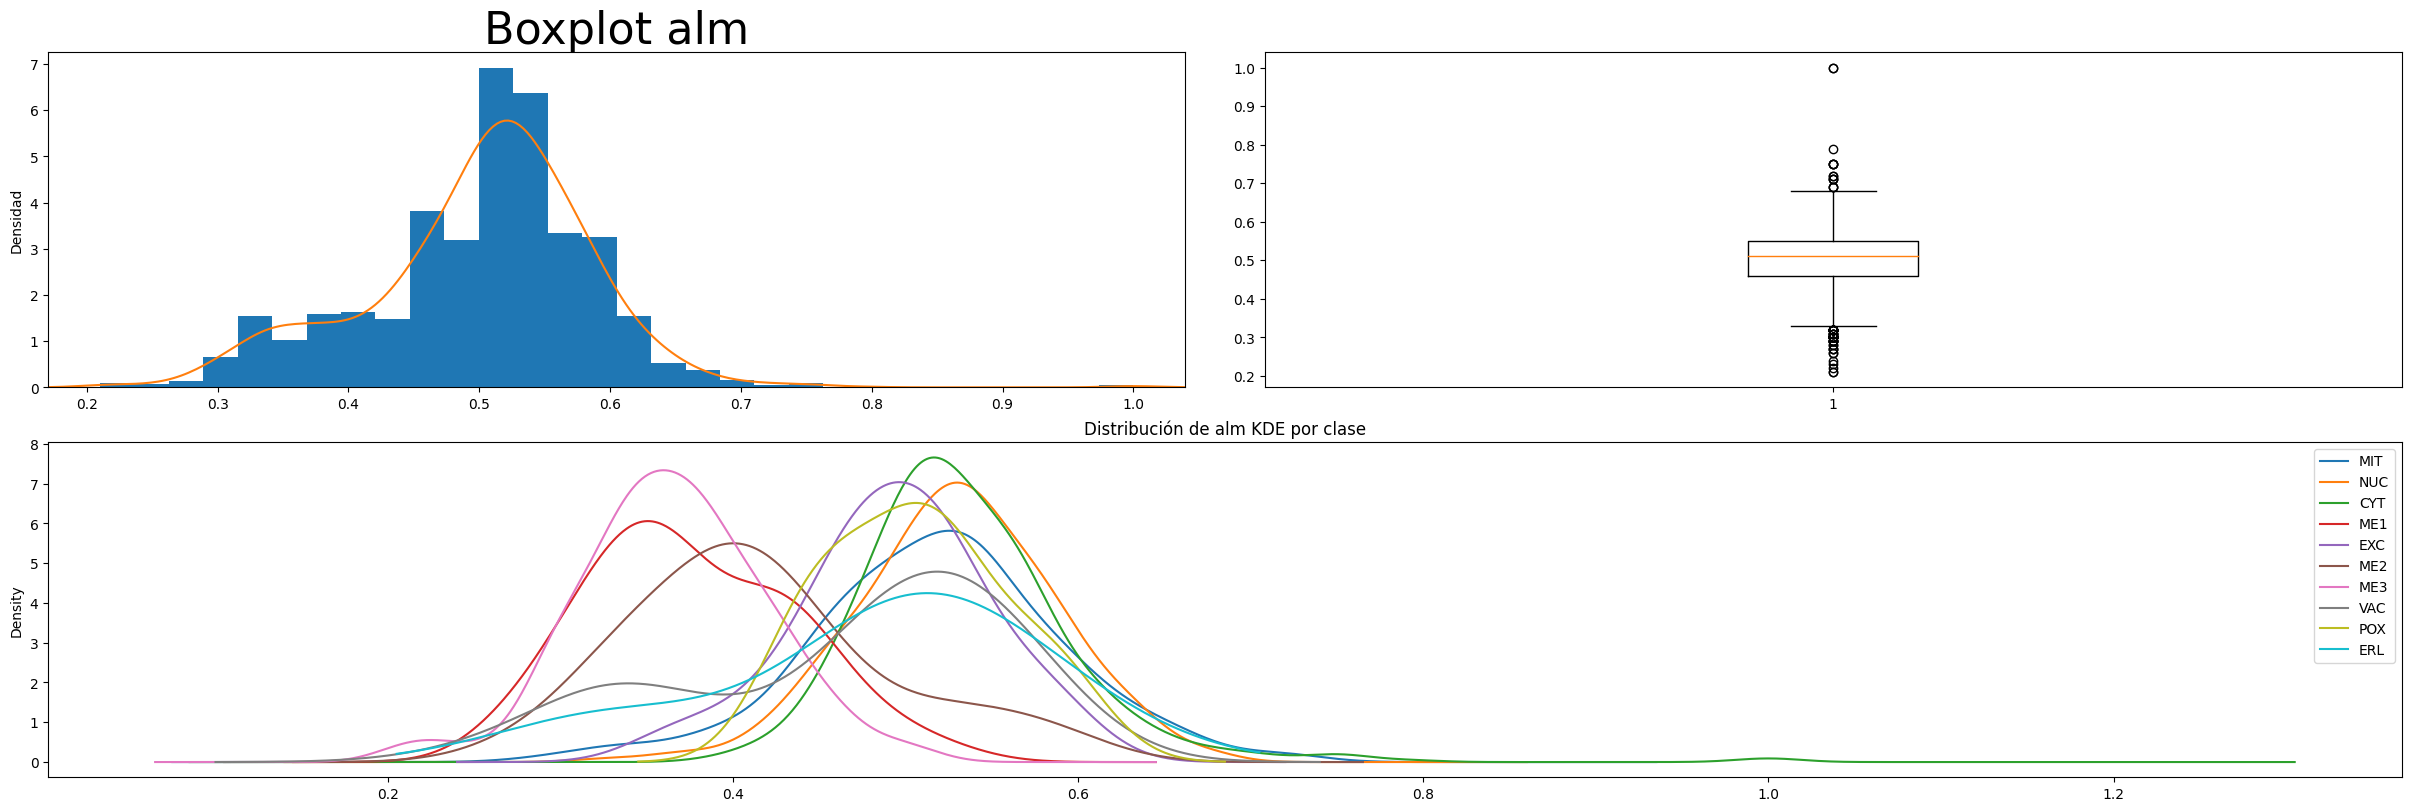

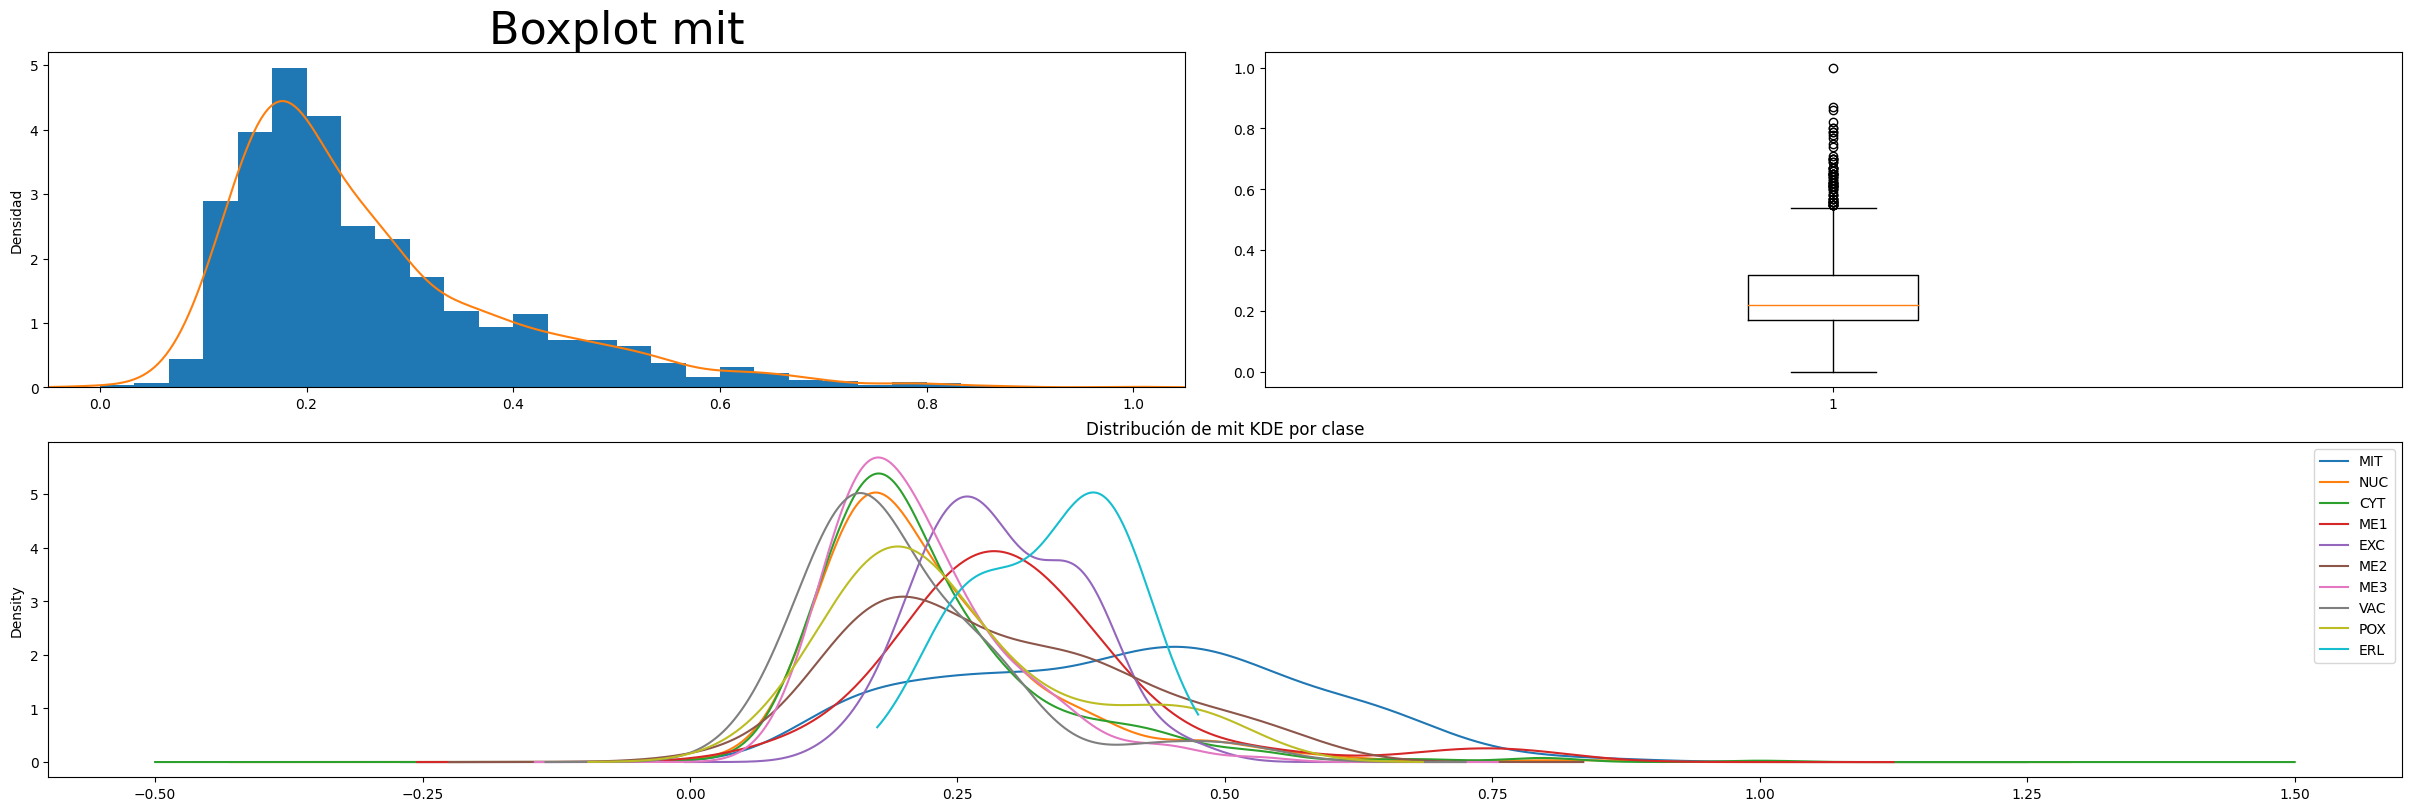

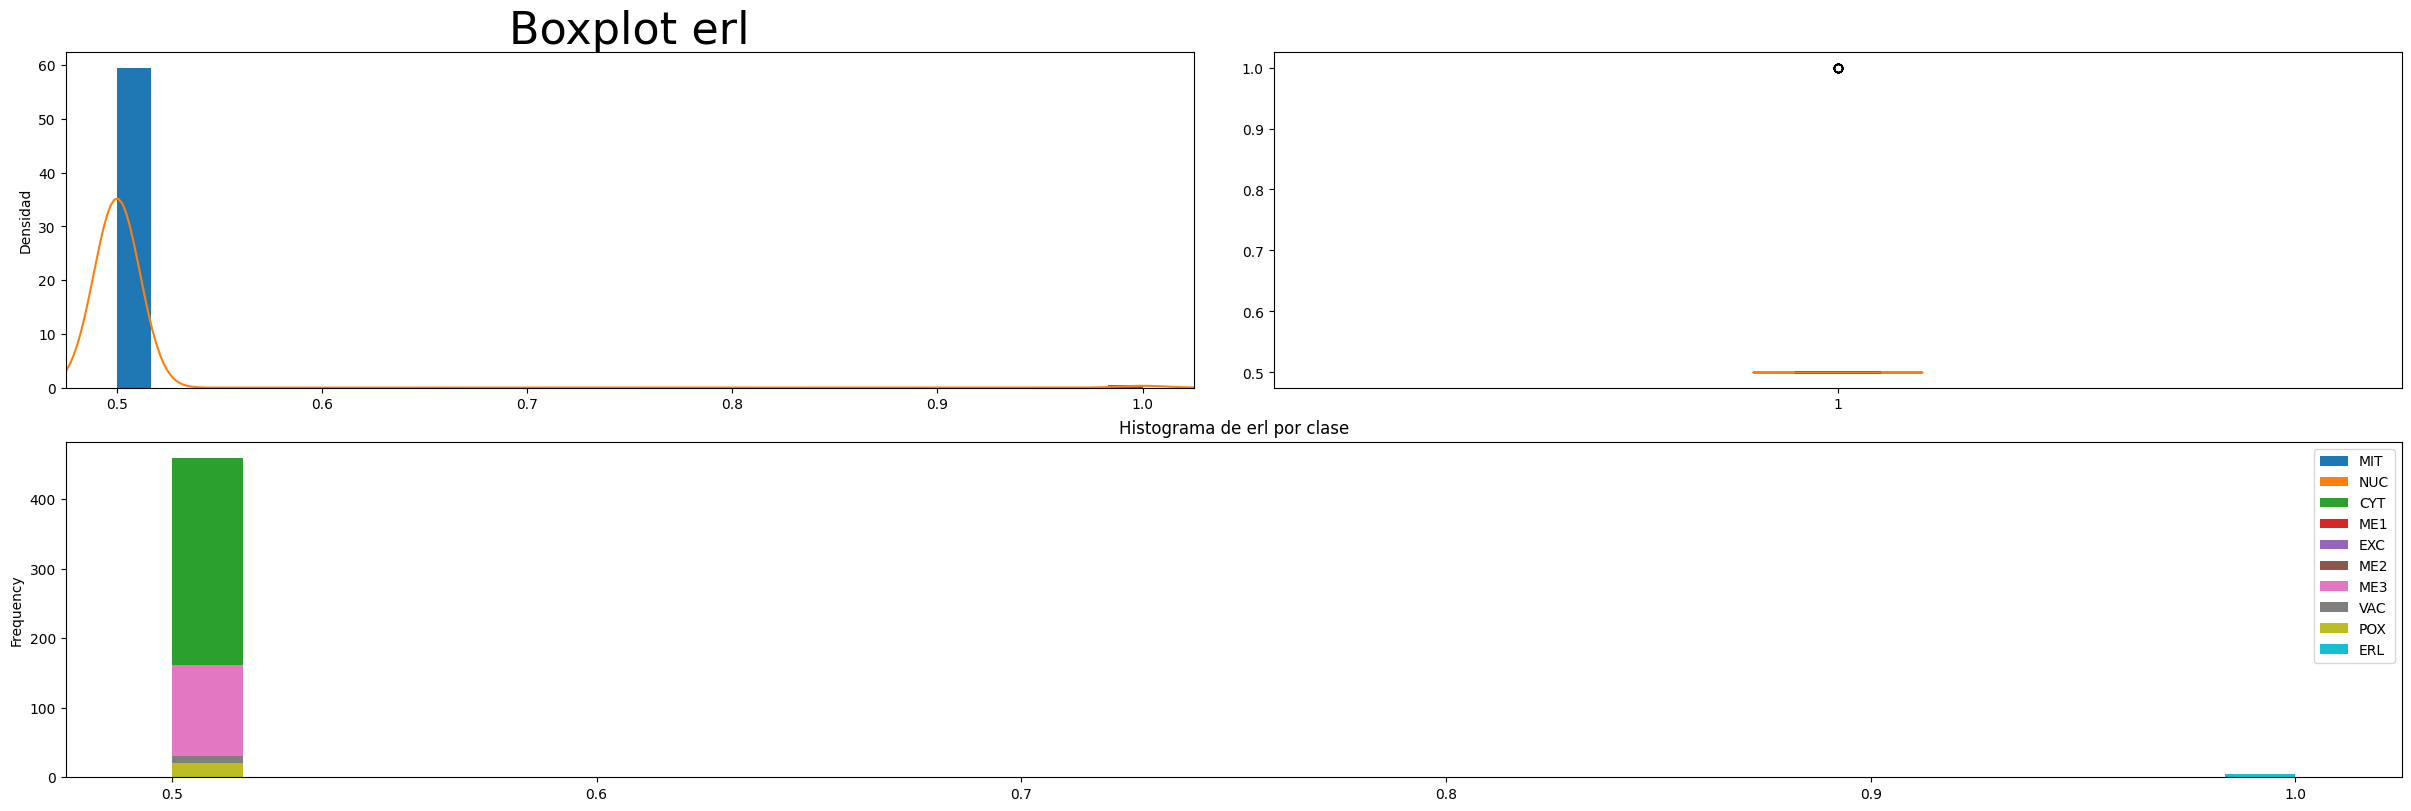

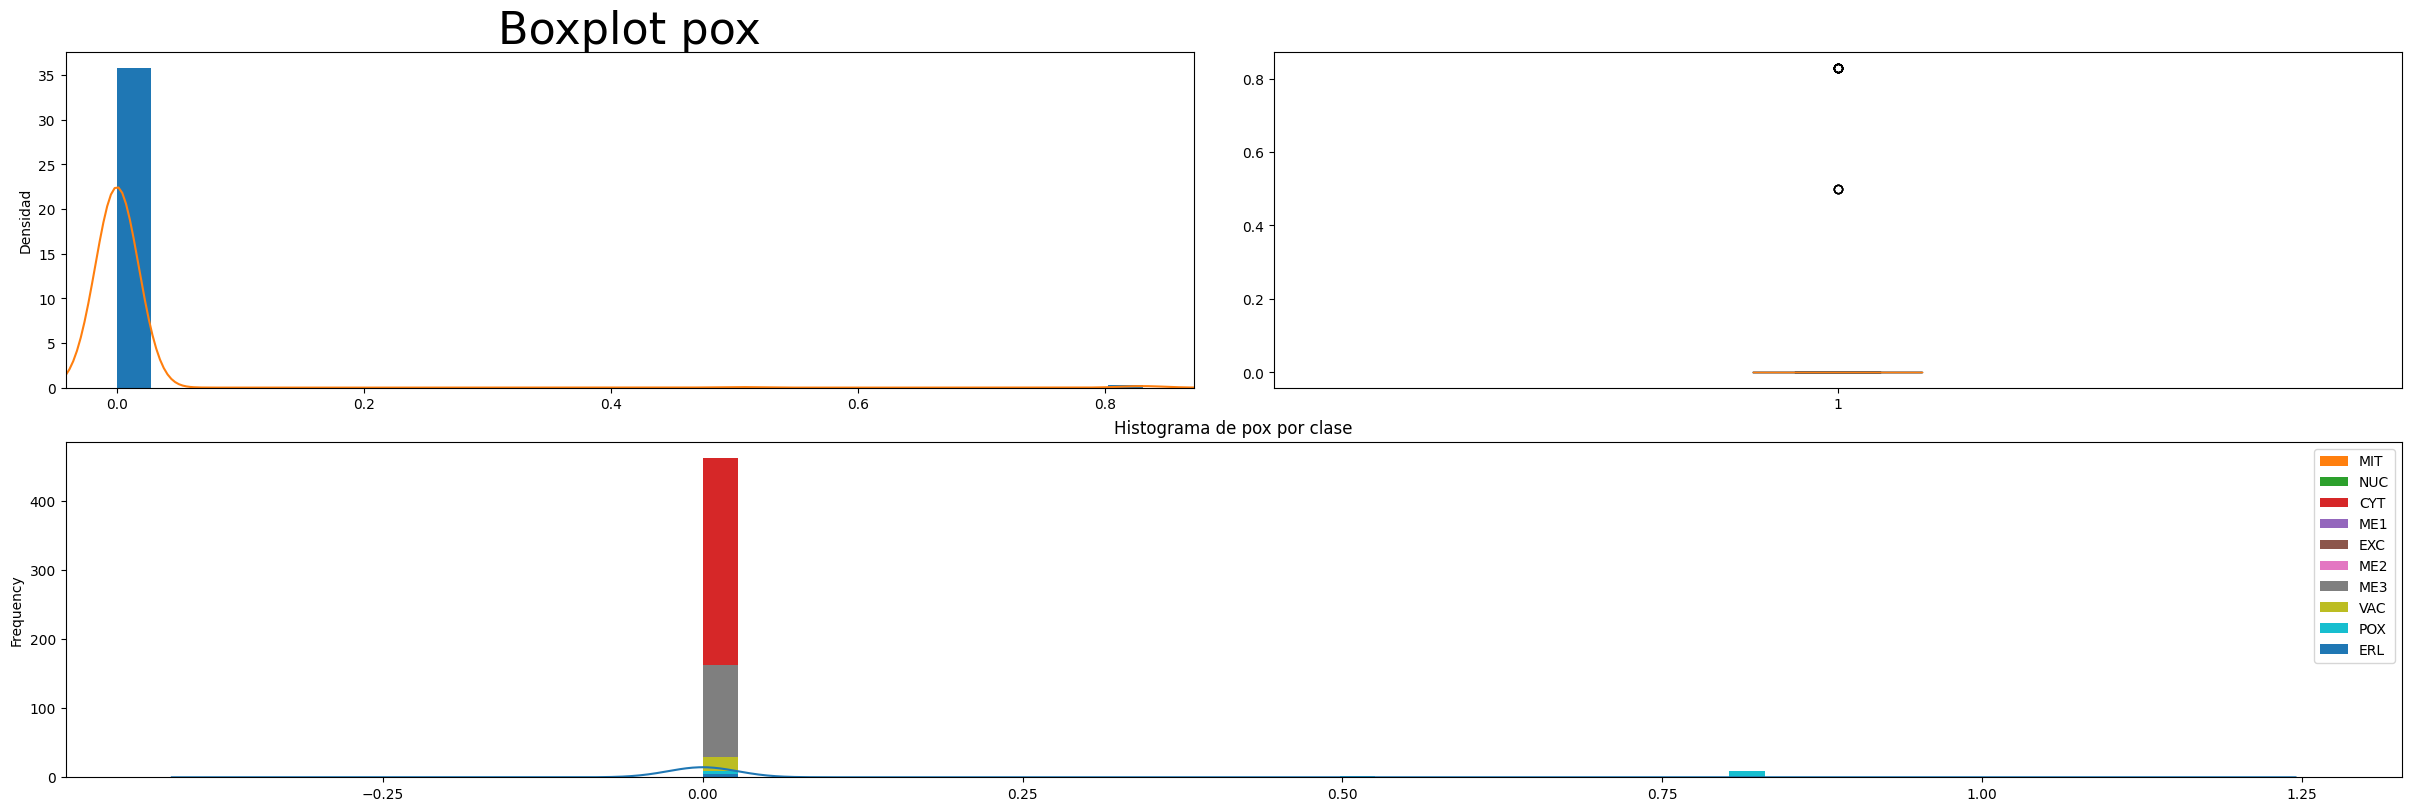

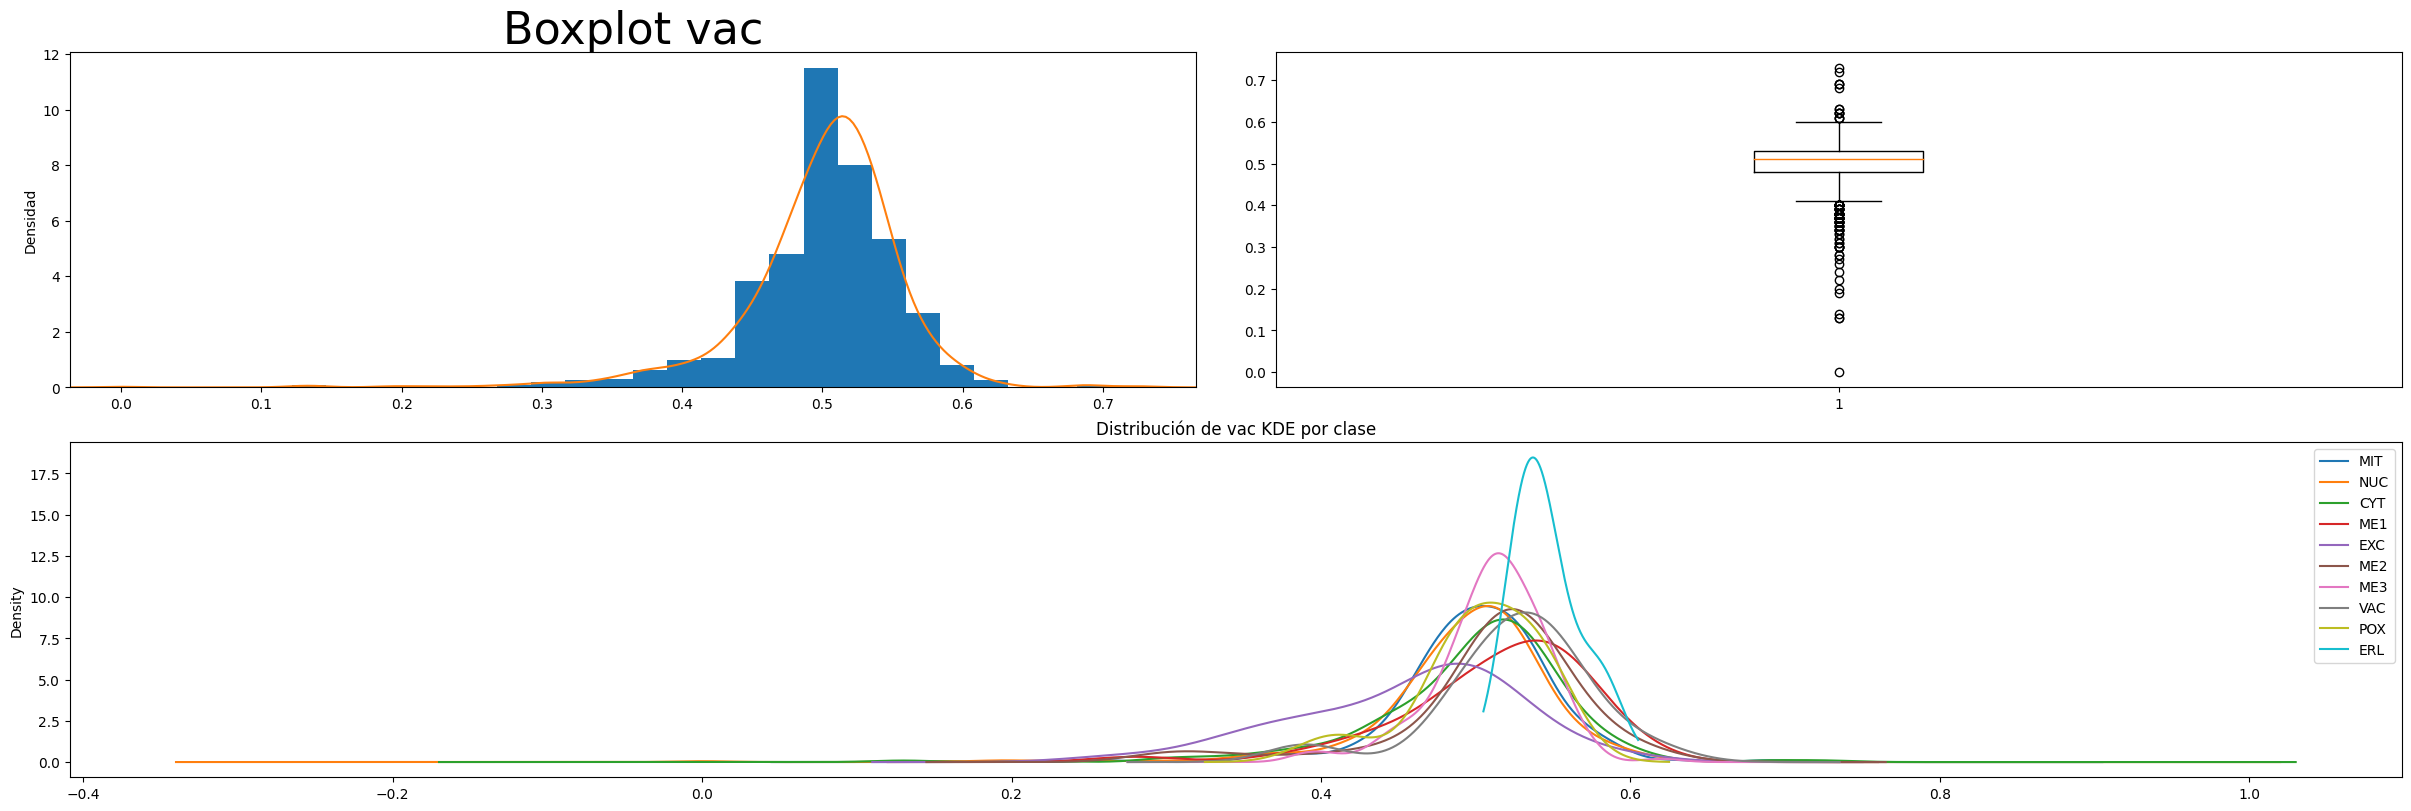

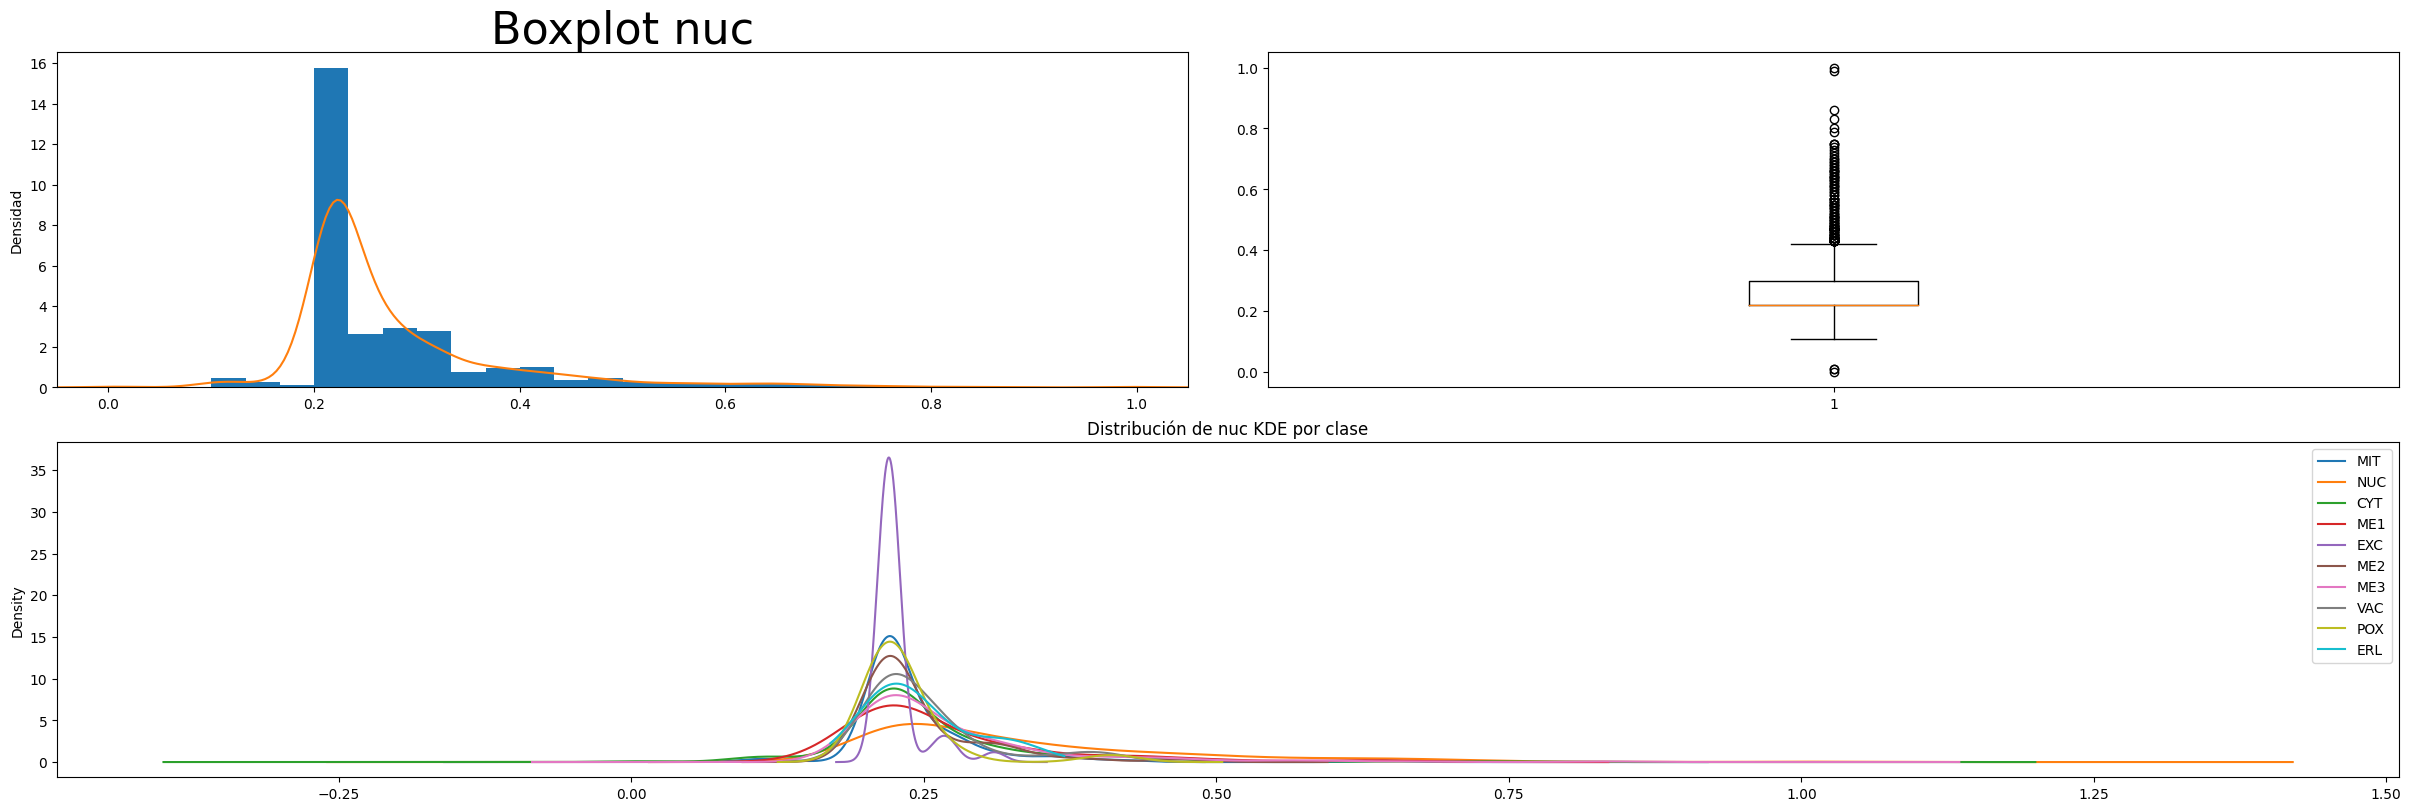

In [31]:
for c in columns:
    nn.compare_param(df,c,30,figsize=(24,8))

In [9]:
df[df["Class"] == "MIT"].describe()

,mcg,gvh,alm,mit,erl,pox,vac,nuc
count,244.000000,244.000000,244.000000,244.000000,244.0,244.000000,244.000000,244.000000
mean,0.521434,0.533238,0.517377,0.404426,0.5,0.008852,0.501680,0.240984
std,0.097238,0.098515,0.072926,0.165850,0.0,0.081364,0.046508,0.056980
min,0.230000,0.180000,0.290000,0.110000,0.5,0.000000,0.260000,0.110000
25%,0.460000,0.470000,0.470000,0.270000,0.5,0.000000,0.480000,0.220000
50%,0.510000,0.530000,0.520000,0.410000,0.5,0.000000,0.500000,0.220000
75%,0.582500,0.590000,0.560000,0.520000,0.5,0.000000,0.530000,0.250000
max,0.810000,1.000000,0.720000,0.870000,0.5,0.830000,0.690000,0.650000


In [10]:
df["erl"].unique()

array([0.5, 1. ])

In [11]:
df["pox"].unique()

array([0.  , 0.5 , 0.83])

Podemos ver a partir de los graficos anteriores y con la función unique, que los valores de erl y pox al ser discretos no pueden ser estimados con una gaussiana y eso se vera reflejado en un error para la clasificación de clases.

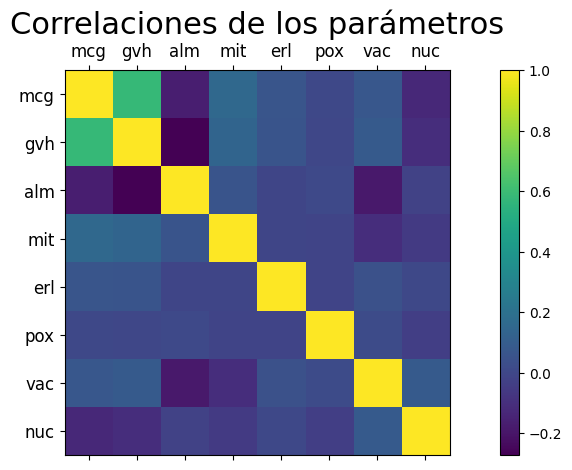

In [12]:
nn.pretty_corr_matrix(df,title="Correlaciones de los parámetros",figsize=(13,5))

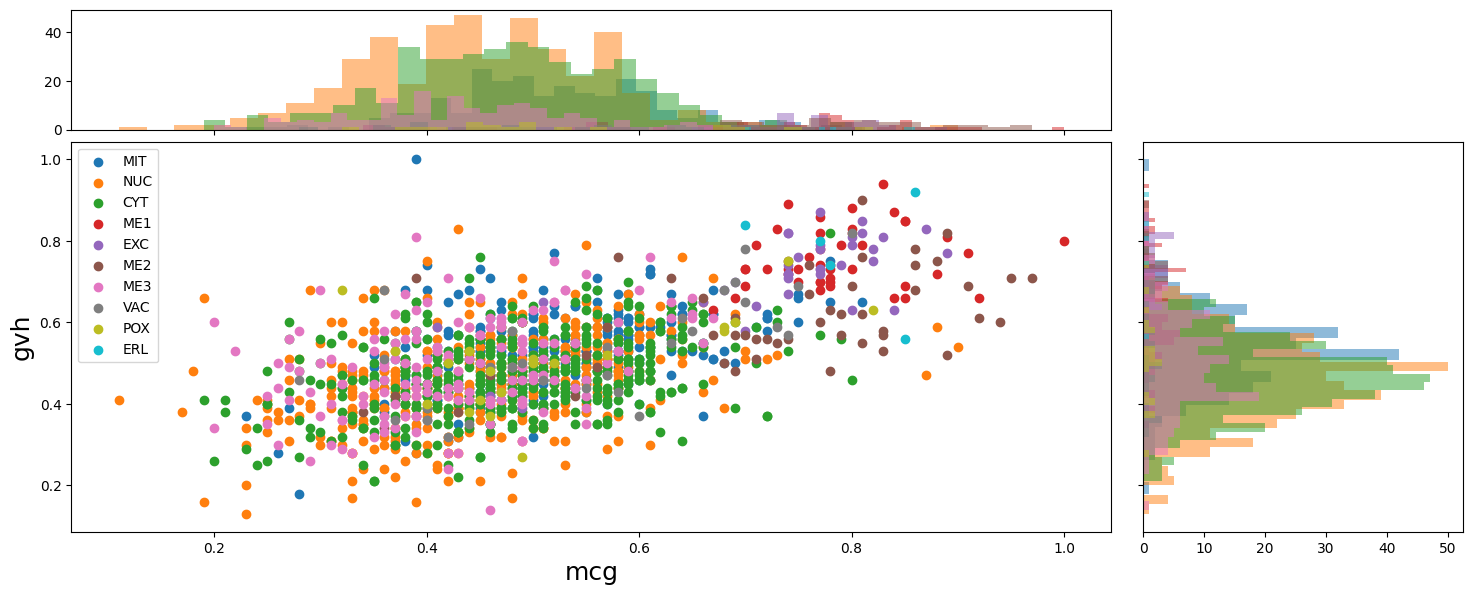

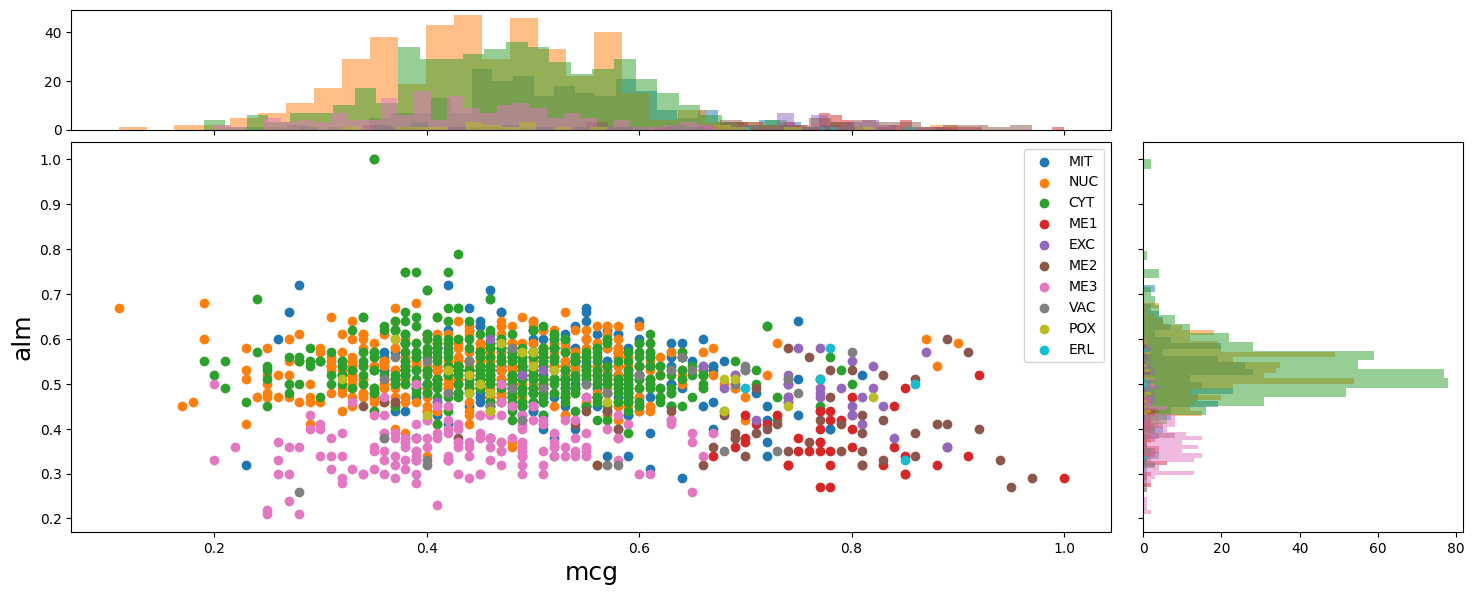

In [13]:
nn.pretty_hist2d(df,df["Class"].drop_duplicates().to_list(),["mcg","gvh"],bins=20)
nn.pretty_hist2d(df,df["Class"].drop_duplicates().to_list(),["mcg","alm"],bins=20)
# nn.pretty_hist2d(df,df["Class"].drop_duplicates().to_list(),["erl","pox"],bins=20)

#### Modelo generativo

In [14]:
probabilities = {}
for clase in clases:
    num = df[df["Class"] == clase].shape[0]
    probabilities[clase] = df[df["Class"] == clase].shape[0]/df.shape[0]

In [34]:
bad_columns = ["erl","pox"]
good_columns = [x for x in columns if x not in bad_columns]
train_df, test_df = train_test_split(df.drop(columns=bad_columns), test_size=0.3)
sample_names = test_df["Class"].to_list()
test = test_df[good_columns].to_numpy()

In [63]:
test_df["label"] = list(map(clases.index,test_df["Class"]))
train_df["label"] = list(map(clases.index,train_df["Class"]))


In [35]:
results = []
for sample,sample_name in zip(test,sample_names):
    results.append(nn.get_yeast_class(sample,train_df,print_res=False))

score = accuracy_score(sample_names, results)
f1_macro = f1_score(sample_names, results, average='macro')
f1_micro = f1_score(sample_names, results, average='micro')
f1_weigt = f1_score(sample_names, results, average='weighted')
f1_noavg = f1_score(sample_names, results, average=None)
print(f"Accuracy: {np.round(score*100,3)}%")
print(f"F1 Macro: {np.round(f1_macro*100,3)}%")
print(f"F1 Micro: {np.round(f1_micro*100,3)}%")
print(f"F1 Class: {np.round(f1_noavg*100,3)}%")


Accuracy: 55.83%
F1 Macro: 39.799%
F1 Micro: 55.83%
F1 Class: [58.462  0.    56.25  64.    33.333 78.351 56.489 51.101  0.     0.   ]%


In [93]:
model = Sequential()
model.add(Dense(len(clases), input_shape =(len(good_columns),), activation="sigmoid"))
model.compile( optimizer = SGD(learning_rate=1e-1),
    loss = "binary_crossentropy", metrics = ["accuracy","AUC"])
    # loss = "categorical_crossentropy"

In [94]:
x_test = test_df[good_columns].values
y_test = to_categorical(test_df["label"].values,num_classes=len(clases))
x_train = train_df[good_columns].values
y_train = to_categorical(train_df["label"].values,num_classes=len(clases))
history = model.fit(
    x = x_train,
    y = y_train,
    validation_data = (x_test,y_test),
    epochs=100, batch_size=12)

Epoch 1/100
87/87 [==============================] - 2s 10ms/step - loss: 0.5658 - accuracy: 0.0482 - auc: 0.5371 - val_loss: 0.4799 - val_accuracy: 0.1928 - val_auc: 0.6499
Epoch 2/100
87/87 [==============================] - 0s 5ms/step - loss: 0.4294 - accuracy: 0.2341 - auc: 0.7211 - val_loss: 0.3926 - val_accuracy: 0.2534 - val_auc: 0.7544
Epoch 3/100
87/87 [==============================] - 1s 8ms/step - loss: 0.3669 - accuracy: 0.2611 - auc: 0.7785 - val_loss: 0.3492 - val_accuracy: 0.2578 - val_auc: 0.7731
Epoch 4/100
87/87 [==============================] - 1s 10ms/step - loss: 0.3339 - accuracy: 0.2707 - auc: 0.7901 - val_loss: 0.3248 - val_accuracy: 0.2848 - val_auc: 0.7749
Epoch 5/100
87/87 [==============================] - 1s 9ms/step - loss: 0.3144 - accuracy: 0.2640 - auc: 0.7920 - val_loss: 0.3096 - val_accuracy: 0.2870 - val_auc: 0.7761
Epoch 6/100
87/87 [==============================] - 1s 9ms/step - loss: 0.3019 - accuracy: 0.2717 - auc: 0.7912 - val_loss: 0.2997 -

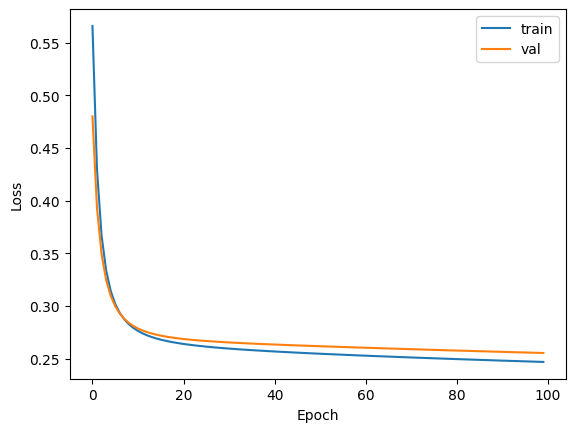

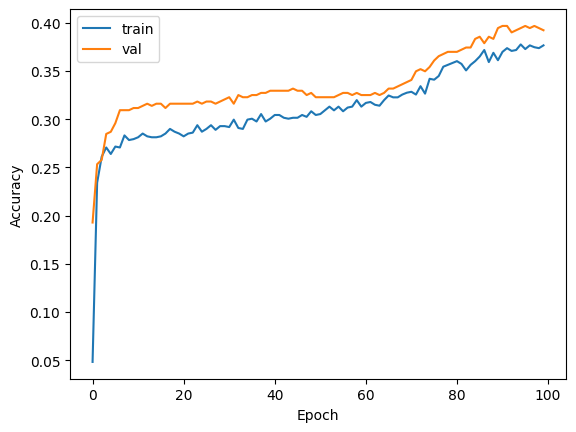

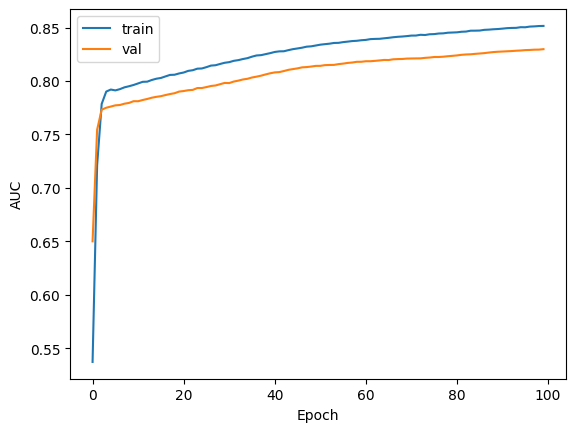

In [95]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()
plt.plot(history.history["auc"], label="train")
plt.plot(history.history["val_auc"], label="val")
plt.ylabel("AUC")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [16]:
tp = fn = tn = fp = 0 
pos_class, neg_class = ("NUC","CYT")
df_two_classes = pd.concat([df[df["Class"] == pos_class],df[df["Class"] == neg_class]], ignore_index=True)

train, test = train_test_split(df_two_classes.drop(columns=bad_columns), test_size=0.3)
sample_names = test["Class"].to_list()
test = test[good_columns].to_numpy()

for sample,sample_name in zip(test,sample_names):
    result = nn.get_yeast_class(sample,train,print_res=False)
    if sample_name == pos_class:
        if result == pos_class: #TP
            tp += 1
        else: #FP
            fn += 1
    else: 
        if result == sample_name: #TN
            tn += 1
        else: #FN
            fp += 1
precission = tp/(tp+fp)
recall =tp/(tp+fn)
f1 = 2*precission*recall/(precission+recall)

In [17]:
print(f1)

0.5550660792951542
